In [1]:
import numpy as np
import pandas as pd
from glob import glob
from subprocess import check_output

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.metrics import r2_score

import pylab as plt
%matplotlib inline

## Get data

In [2]:
with open('pipeline_data/steps.dat', 'r') as handle:
    steps = handle.readline().strip().split()
    
ns = len(steps)

steps_c = [f'case{i}' for i in range(ns)]
steps_d = [f'death{i}' for i in range(ns)]
steps_ = steps_c + steps_d

In [3]:
data_fname = glob('pipeline_data/data_????-??-??.csv')[0]

# Get the two totals
last_date = data_fname.split('/')[-1][:-4].split('_')[-1]
print(f'last date = {last_date}')
steps_c = steps_c + [f'total_case']
steps_d = steps_d + [f'total_death']
steps_ = steps_c + steps_d

df = pd.read_csv(data_fname, dtype={'fips': str}).set_index('fips')
# tmp = df[[col for col in df.columns if col.startswith('case') or col.startswith('death')]]
# (tmp < 0).sum()

last date = 2020-12-05


In [4]:
df['urban_risk'] = df['perc_urban_pop'] * (df['risk_flu'] - df['risk_flu'].min())
covariates = [
    'population', 
    'perc_65yrs', 
    'perc_minority', 
    'perc_black', 
    'perc_hispanic', 
    'perc_poverty', 
    'perc_urban_pop',
    'income',
    'risk_flu',
    'urban_risk'
]

df_z = df[steps_].copy()
for c in covariates:
    mean, std = df[c].mean(), df[c].std()
    df_z[c] = (df[c] - mean) / std
df_z.head()

case0  case1  case2  case3  case4  case5  case6  case7  case8  case9  \
fips                                                                          
01001   12.0    7.0    6.0   11.0   11.0   16.0   45.0   48.0   60.0   48.0   
01003   34.0   36.0   40.0   45.0   30.0   34.0   42.0   19.0   12.0   29.0   
01005    3.0    7.0    8.0   16.0    9.0   14.0   24.0   27.0   47.0   41.0   
01007    4.0    9.0   13.0    8.0    7.0    4.0    7.0    7.0   15.0    5.0   
01009   12.0    3.0    9.0   12.0    6.0    5.0    2.0    3.0   13.0   11.0   

       ...  population  perc_65yrs  perc_minority  perc_black  perc_hispanic  \
fips   ...                                                                     
01001  ...   -0.149053   -0.794106       0.512705    0.741329      -0.489703   
01003  ...    0.349320    0.257409      -0.180113   -0.042334      -0.365711   
01005  ...   -0.241908   -0.012923       2.192825    2.685016      -0.379632   
01007  ...   -0.248733   -0.647773       0.481481    0.821243      -0.504693   
01009  ...   -0.143225   -0.221003      -0.699751   -0.532156      -0.011632   

       perc_poverty  perc_urban_pop    income  risk_flu  urban_risk  
fips                                                                 
01001     -0.225017        0.535824  0.480936  1.006875    0.666999  
01003     -0.883379        0.526204  0.353735  1.296454    0.817850  
01005      2.589482       -0.291414 -1.333023  0.420657   -0.240836  
01007      1.091708       -0.310652 -0.483902  0.436170   -0.249735  
01009     -0.323771       -1.003223 -0.167862  0.617627   -0.724261  

[5 rows x 84 columns]

## Get GLM predictions

In [5]:
cov_prefix = 'population+perc_65yrs+perc_minority+perc_black+perc_hispanic+perc_poverty+income+'
cov = cov_prefix + 'perc_urban_pop+risk_flu+urban_risk'

### Case 

In [6]:
dfs_case = []
cors = []
for i in range(len(steps_c)):
    cur = steps_c[i]
    formula = f'{cur}~{cov}'

    model = smf.glm(
        formula=formula,
        data=df_z,
        family=sm.families.Poisson(sm.families.links.log())
    ).fit()
    print(f'{model.summary()}\n\n')
    
    prd = model.predict()
    cor = pd.DataFrame(
        data={'prd': prd, 'grd': df_z[cur].values}, 
        index=df.index).corr().loc['prd', 'grd']
    cors.append(cor)
    
    df_z[cur + '_glm'] = model.predict()
    
    dfs_case.append(pd.read_html(model.summary().tables[1].as_html(), header=0, index_col=0)[0])

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  case0   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.1220e+05
Date:                Sun, 06 Dec 2020   Deviance:                   4.1453e+05
Time:                        16:45:49   Pearson chi2:                 7.17e+05
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.0975      0.007    281.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  case4   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.3448e+05
Date:                Sun, 06 Dec 2020   Deviance:                   2.5966e+05
Time:                        16:45:50   Pearson chi2:                 1.13e+06
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.5840      0.006    403.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  case8   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -70378.
Date:                Sun, 06 Dec 2020   Deviance:                   1.3104e+05
Time:                        16:45:50   Pearson chi2:                 2.42e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.5176      0.007    373.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 case12   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0508e+05
Date:                Sun, 06 Dec 2020   Deviance:                   1.9846e+05
Time:                        16:45:50   Pearson chi2:                 3.25e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.8685      0.006    478.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 case16   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.3802e+05
Date:                Sun, 06 Dec 2020   Deviance:                   2.6124e+05
Time:                        16:45:51   Pearson chi2:                 3.53e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.6194      0.004    927.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 case20   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -84365.
Date:                Sun, 06 Dec 2020   Deviance:                   1.5432e+05
Time:                        16:45:51   Pearson chi2:                 1.90e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.4446      0.004    835.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 case24   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -80193.
Date:                Sun, 06 Dec 2020   Deviance:                   1.4542e+05
Time:                        16:45:51   Pearson chi2:                 1.93e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.6028      0.004    965.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 case28   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -96898.
Date:                Sun, 06 Dec 2020   Deviance:                   1.7717e+05
Time:                        16:45:51   Pearson chi2:                 2.18e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          4.0122      0.003   1371.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 case32   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.4570e+05
Date:                Sun, 06 Dec 2020   Deviance:                   4.7198e+05
Time:                        16:45:52   Pearson chi2:                 5.99e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          4.8445      0.002   2509.

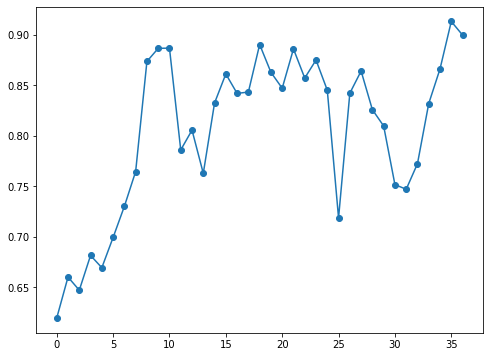

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(cors, marker='o')

### Death

In [8]:
dfs_death = []
cors = []
for i in range(len(steps_d)):
    cur = steps_d[i]
    formula = f'{cur}~{cov}'

    model = smf.glm(
        formula=formula,
        data=df_z,
        family=sm.families.Poisson(sm.families.links.log())
    ).fit()
    print(f'{model.summary()}\n\n')
    
    prd = model.predict()
    cor = pd.DataFrame(
        data={'prd': prd, 'grd': df_z[cur].values}, 
        index=df.index).corr().loc['prd', 'grd']
    cors.append(cor)
    
    df_z[cur + '_glm'] = model.predict()
    
    dfs_death.append(pd.read_html(model.summary().tables[1].as_html(), header=0, index_col=0)[0])

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 death0   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10286.
Date:                Sun, 06 Dec 2020   Deviance:                       18515.
Time:                        16:46:27   Pearson chi2:                 5.60e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.3126      0.050    -46.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 death6   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9070.1
Date:                Sun, 06 Dec 2020   Deviance:                       15554.
Time:                        16:46:27   Pearson chi2:                 3.91e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.6307      0.034    -18.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death13   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3715.8
Date:                Sun, 06 Dec 2020   Deviance:                       5410.7
Time:                        16:46:28   Pearson chi2:                 1.17e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.2558      0.045    -27.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death19   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5376.3
Date:                Sun, 06 Dec 2020   Deviance:                       7389.7
Time:                        16:46:28   Pearson chi2:                 1.02e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.5377      0.030    -17.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death26   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4784.3
Date:                Sun, 06 Dec 2020   Deviance:                       6134.2
Time:                        16:46:29   Pearson chi2:                 8.32e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.3608      0.026    -13.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death30   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5550.4
Date:                Sun, 06 Dec 2020   Deviance:                       6983.9
Time:                        16:46:29   Pearson chi2:                 9.48e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0145      0.021      0.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death34   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7763.1
Date:                Sun, 06 Dec 2020   Deviance:                       10071.
Time:                        16:46:29   Pearson chi2:                 1.28e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.5234      0.016     32.

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(cors, marker='o')

In [10]:
# cleanup and save
existing_csv = glob('pipeline_data/data_????-??-??_glm.csv')

if len(existing_csv) > 0:
    for csv in existing_csv:
        check_output(f'rm {csv}', shell=True)
        
df_z.to_csv(data_fname[:-4] + '_glm.csv', float_format='%.2f')

## Validation

In [11]:
cols = [col for col in df_z.columns if (col.startswith('case')) or (col.startswith('death'))]
(df_z[cols] < 0).sum().sum()

0

## Get latex tables
Let us save them to the urisk folder directly for now

In [41]:
save_folder = '/home/yihuang/Documents/TEX/pub_ds2_/urisk/Figures/data/'

In [42]:
index_name_map = {
    'population': '\\texttt{pop}',
    'perc 65yrs': '\\texttt{$\%65+$}',     
    'perc minority': '\\texttt{$\%$minority}',
    'perc black': '\\texttt{$\%$black}',
    'perc hispanic': '\\texttt{$\%$hispanic}',
    'perc poverty': '\\texttt{$\%$poverty}',
    'income': '\\texttt{income}',
    'perc urban pop': '\\texttt{$\%$urban}',
    'risk flu': '\\texttt{\\unit}',
    'urban risk': '\\texttt{urban \\unit}',
}
column_name_map = {
    'z-value': '$z$-value',
    '0.025': '$.025$',
    '0.975': '$.975$',
}

In [43]:
cols = ['coef', 'z', '[0.025', '0.975]']
cols_modified = ['coef.', 'z-value', '0.025', '0.975']
df_total_case = dfs_case[-1][cols]
df_total_case.rename(columns={c: c_prime for c, c_prime in zip(cols, cols_modified)}, inplace=True)
df_total_case.rename(index={x: x.replace('_', ' ') for x in df_total_case.index}, inplace=True)

df_total_case.drop('Intercept', inplace=True)
df_total_case.rename(index=index_name_map, inplace=True)
df_total_case.rename(columns=column_name_map, inplace=True)

tab_case = df_total_case.to_latex(formatters={col: lambda x: f'${x:.3f}$' for col in cols_modified}, escape=False)

print(tab_case)

save_fname_case = f'{save_folder}/total_case.tab'
with open(save_fname_case, 'w') as handle:
    handle.write(tab_case)

\begin{tabular}{lrrrr}
\toprule
{} &    coef. &  $z$-value &  $.025$ &  $.975$ \\
\midrule
\texttt{pop}          &  $0.081$ &   1462.981 &   0.081 &   0.081 \\
\texttt{$\%65+$}      & $-0.120$ &   -294.389 &  -0.121 &  -0.119 \\
\texttt{$\%$minority} & $-0.035$ &    -44.687 &  -0.036 &  -0.033 \\
\texttt{$\%$black}    & $-0.011$ &    -14.446 &  -0.012 &  -0.009 \\
\texttt{$\%$hispanic} & $-0.006$ &    -19.511 &  -0.006 &  -0.005 \\
\texttt{$\%$poverty}  & $-0.168$ &   -257.154 &  -0.169 &  -0.166 \\
\texttt{income}       & $-0.189$ &   -408.987 &  -0.190 &  -0.188 \\
\texttt{$\%$urban}    &  $0.081$ &     75.633 &   0.079 &   0.083 \\
\texttt{\unit}        &  $0.113$ &    109.036 &   0.111 &   0.115 \\
\texttt{urban \unit}  &  $0.998$ &    753.616 &   0.995 &   1.000 \\
\bottomrule
\end{tabular}



In [44]:
cols = ['coef', 'z', '[0.025', '0.975]']
cols_modified = ['coef.', 'z-value', '0.025', '0.975']
df_total_death = dfs_death[-1][cols]
df_total_death.rename(columns={c: c_prime for c, c_prime in zip(cols, cols_modified)}, inplace=True)
df_total_death.rename(index={x: x.replace('_', ' ') for x in df_total_death.index}, inplace=True)

df_total_death.drop('Intercept', inplace=True)
df_total_death.rename(index=index_name_map, inplace=True)
df_total_death.rename(columns=column_name_map, inplace=True)

tab_death = df_total_death.to_latex(formatters={col: lambda x: f'${x:.3f}$' for col in cols_modified}, escape=False)

print(tab_death)

save_fname_death = f'{save_folder}/total_death.tab'
with open(save_fname_death, 'w') as handle:
    handle.write(tab_death)

\begin{tabular}{lrrrr}
\toprule
{} &    coef. &  $z$-value &  $.025$ &  $.975$ \\
\midrule
\texttt{pop}          &  $0.069$ &    174.380 &   0.068 &   0.069 \\
\texttt{$\%65+$}      &  $0.242$ &     95.409 &   0.237 &   0.247 \\
\texttt{$\%$minority} &  $0.120$ &     23.583 &   0.110 &   0.130 \\
\texttt{$\%$black}    &  $0.056$ &     12.001 &   0.047 &   0.066 \\
\texttt{$\%$hispanic} &  $0.080$ &     39.387 &   0.076 &   0.084 \\
\texttt{$\%$poverty}  &  $0.140$ &     32.421 &   0.132 &   0.149 \\
\texttt{income}       &  $0.033$ &     11.232 &   0.028 &   0.039 \\
\texttt{$\%$urban}    & $-0.033$ &     -4.119 &  -0.049 &  -0.017 \\
\texttt{\unit}        &  $0.208$ &     26.708 &   0.193 &   0.223 \\
\texttt{urban \unit}  &  $1.109$ &    113.827 &   1.090 &   1.128 \\
\bottomrule
\end{tabular}



In [45]:
cols = ['coef', 'z', 'P>|z|', '[0.025', '0.975]']
cols_modified = ['coef.', 'z-value', 'p-value', '0.025', '0.975']

inds = [
    'Intercept', 'population', 
    'perc_65yrs', 'perc_minority', 
    'perc_black', 'perc_hispanic', 
    'perc_poverty', 'income', 
    'perc_urban_pop', 
    'risk_flu', 'urban_risk'
]
inds_modified = [
    'Intercept', 'pop', 
    '$\%65+$', '$\%$minority', 
    '$\%$black', '$\%$hispanic', 
    '$\%$poverty', 'income', 
    '$\%$urban', 
    'pre-UnIT', 'UnIT'
]

In [46]:
for i, s in enumerate(steps):
    print(f'{i}: {s}')

0: 2020-04-04
1: 2020-04-11
2: 2020-04-18
3: 2020-04-25
4: 2020-05-02
5: 2020-05-09
6: 2020-05-16
7: 2020-05-23
8: 2020-05-30
9: 2020-06-06
10: 2020-06-13
11: 2020-06-20
12: 2020-06-27
13: 2020-07-04
14: 2020-07-11
15: 2020-07-18
16: 2020-07-25
17: 2020-08-01
18: 2020-08-08
19: 2020-08-15
20: 2020-08-22
21: 2020-08-29
22: 2020-09-05
23: 2020-09-12
24: 2020-09-19
25: 2020-09-26
26: 2020-10-03
27: 2020-10-10
28: 2020-10-17
29: 2020-10-24
30: 2020-10-31
31: 2020-11-07
32: 2020-11-14
33: 2020-11-21
34: 2020-11-28
35: 2020-12-05


In [47]:
def foo(x):
    y = abs(x)
    if y < 1:
        return f'${x:.3f}$'
    elif (y >= 1) and (y < 10):
        return f'${x:.2f}$'
    else:
        return f'${x:.1f}$'

In [48]:
start = 19
mydict = {'case': dfs_case, 'death': dfs_death}
for target, dfs in mydict.items():
    data = {}
    abnormal_p_values = []
    for i in range(start, len(steps)):

        tmp_df = dfs[i][cols].copy()
        tmp_df.drop('Intercept', axis=0, inplace=True)
        tmp_df = tmp_df.rename(columns={c: c_prime for c, c_prime in zip(cols, cols_modified)}).T
        tmp_df = tmp_df.rename(columns={c: c_prime for c, c_prime in zip(inds, inds_modified)}).T
        
        for col in ['z-value', '0.025', '0.975']:
            key = (steps[i][5:], column_name_map[col])
            data[key] = [foo(x) for x in tmp_df[col]]
        
        key = (steps[i][5:], 'coef.')
        coefs = []
        for idx in tmp_df.index:
            value = foo(tmp_df.loc[idx, 'coef.'])
            if tmp_df.loc[idx, 'p-value'] < 0.01:
                coefs.append("{}".format(value))
            elif tmp_df.loc[idx, 'p-value'] >= 0.01 and tmp_df.loc[idx, 'p-value'] < 0.05:
                coefs.append("\\textcolor{{{}}}{{{}}}".format('blue', value))
            else:
                coefs.append("\\textcolor{{{}}}{{{}}}".format('red', value))
        data[key] = coefs

    index = [f'\\texttt{{{idx}}}' for idx in tmp_df.index]
    df = pd.DataFrame(data=data, index=index).T
    print(df)
    
    tab_weekly = df.to_latex( 
        escape=False, 
        multirow=True)

    save_fname = f'{save_folder}/weekly_{target}_{steps[start]}.tab'
    with open(save_fname, 'w') as handle:
        handle.write(tab_weekly)

                \texttt{pop} \texttt{$\%65+$}      \texttt{$\%$minority}  \
08-15 $z$-value      $189.4$          $-15.2$                     $75.2$   
      $.025$         $0.062$         $-0.045$                    $0.305$   
      $.975$         $0.063$         $-0.035$                    $0.321$   
      coef.          $0.062$         $-0.040$                    $0.313$   
08-22 $z$-value      $181.4$          $-50.6$                     $66.3$   
      $.025$         $0.066$         $-0.155$                    $0.287$   
      $.975$         $0.067$         $-0.143$                    $0.304$   
      coef.          $0.067$         $-0.149$                    $0.296$   
08-29 $z$-value      $190.2$          $-83.5$                     $40.1$   
      $.025$         $0.073$         $-0.265$                    $0.174$   
      $.975$         $0.075$         $-0.253$                    $0.191$   
      coef.          $0.074$         $-0.259$                    $0.182$   
09-05 $z$-va